In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
#from mordred import Calculator, descriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
import matplotlib.pyplot as plt


from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv("pIC50.csv")
df

,Unnamed: 0,cid,smiles,bioactivity,type,value (nM),pIC50
0,0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,Active,IC50,0.0138,10.860121
1,1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,Active,IC50,0.0138,10.860121
2,2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,Active,IC50,0.0378,10.422508
3,3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,Active,IC50,0.0626,10.203426
4,4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,Active,IC50,2.0000,8.698970
...,...,...,...,...,...,...,...
401,401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,340200.0000,3.468266
402,402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,Inactive,IC50,341500.0000,3.466609
403,403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,Inactive,IC50,362900.0000,3.440213
404,404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,391000.0000,3.407823


In [3]:
#from sklearn.datasets import load_iris

In [4]:
#iris = load_iris()
#
#iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
#iris_df.head()
#iris_df.shape
#

In [5]:
#iris_X = np.array(iris_df)
#iris_X

In [6]:
    #iris_df['target'] = iris.target
    #iris_y = np.array(iris_df['target'])
    #iris_y.shape

<Figure size 2000x2000 with 0 Axes>

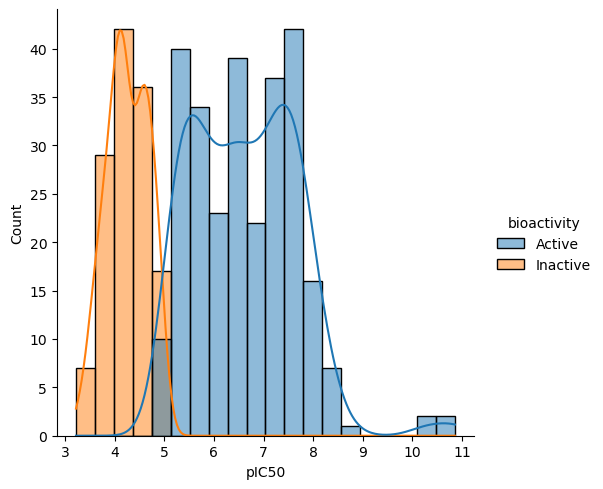

In [7]:
plt.figure(figsize=(20, 20))

sns.displot(df, bins=20, x='pIC50', hue='bioactivity', kde=True)
plt.show()

In [8]:
df2 = df[["cid", "smiles", "pIC50"]]
df2

,cid,smiles,pIC50
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970
...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823


In [9]:
df2["activity_label"] = np.zeros(len(df2))

df2.loc[df2[df2.pIC50 >= 5].index, "activity_label"] = 1.0

print("Number of active molecules:", int(df2.activity_label.sum()))
print("Number of inactive molecules:", len(df2) - int(df2.activity_label.sum()))

df

Number of active molecules: 275
Number of inactive molecules: 131


C:\Users\supak\AppData\Local\Temp\ipykernel_15144\901482849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["activity_label"] = np.zeros(len(df2))


,Unnamed: 0,cid,smiles,bioactivity,type,value (nM),pIC50
0,0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,Active,IC50,0.0138,10.860121
1,1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,Active,IC50,0.0138,10.860121
2,2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,Active,IC50,0.0378,10.422508
3,3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,Active,IC50,0.0626,10.203426
4,4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,Active,IC50,2.0000,8.698970
...,...,...,...,...,...,...,...
401,401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,340200.0000,3.468266
402,402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,Inactive,IC50,341500.0000,3.466609
403,403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,Inactive,IC50,362900.0000,3.440213
404,404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,Inactive,IC50,391000.0000,3.407823


Create Fingerprint

In [10]:
def fingerprints(smiles, method="maccs", n_bits=2048):

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan4":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=4, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [11]:
compound_df = df2.copy()

compound_df["fp"] = compound_df["smiles"].apply(fingerprints)
compound_df

,cid,smiles,pIC50,activity_label,fp
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


ML Functions for Fingerprint

In [12]:
#Plot Data
def plot_curve_functions(models, test_x, test_y):
    
    fig, ax = plt.subplots()
    
    
    #Loop iterates model list
    for model in models:
        
        #Select model
        ml_model = model["model"]
        
        #Predict test probability
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        
        #Predict class on test set
        test_pred = ml_model.predict(test_x)
        
        #Compute False/True postitive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        
        #Calculate AUC
        auc = roc_auc_score(test_y, test_prob)
        
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.5f}"))
    
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

    #if save_png:
        #fig.savefig(dpi=300, bbox_inches="tight", transparent=True)
    #return fig

In [13]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    
    #Predict probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]
    
    #Predict class on test set
    test_pred = ml_model.predict(test_x)
    
    #Performance of test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
    spec = recall_score(test_y, test_pred, pos_label=0)#, average='macro)
    auc = roc_auc_score(test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
    cm = confusion_matrix(test_y, test_pred)
    
    if verbose:
        print(f"Accuracy: {accuracy:.5f}")
        print(f"Sensitivity: {sens:.5f}")
        print(f"Specificity: {spec:.5f}")
        print(f"AUC: {auc:.5f}")
        print(f"Confusion Matrix: {cm}")

    return accuracy, sens, spec, auc, cm

In [14]:
def model_training_and_validation(ml_model, name, splits, verbose=True):

    train_x, test_x, train_y, test_y = splits

    #Fit model
    ml_model.fit(train_x, train_y)

    #Calculate performance results
    accuracy, sens, spec, auc, cm = model_performance(ml_model, test_x, test_y, verbose)
    
    sns.heatmap(cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    
    return accuracy, sens, spec, auc, cm

Split Data

In [15]:
fp_to_model = compound_df.fp.tolist()
label_to_model = compound_df.activity_label.tolist()


(static_train_x, 
 static_test_x, 
 static_train_y,
 static_test_y) = train_test_split(fp_to_model, label_to_model, 
                                   test_size=0.2, random_state=42)

splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))


Training data size: 324
Test data size: 82


Random Forest

In [16]:
param = {
    "n_estimators": 40,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

Accuracy: 0.97561
Sensitivity: 0.98276
Specificity: 0.95833
AUC: 0.99856
Confusion Matrix: [[23  1]
 [ 1 57]]


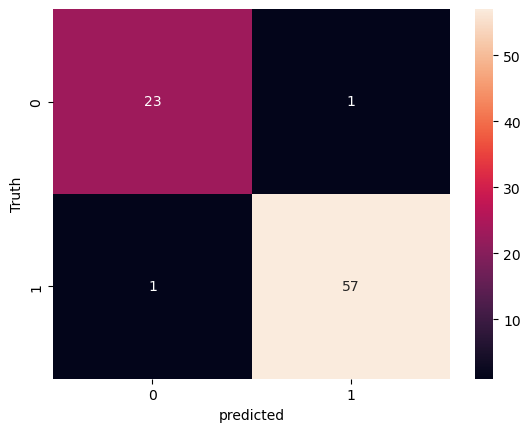

In [17]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

In [18]:
#feature_iris = pd.Series(model_RF.feature_importances_, index=compound_df.fp).sort_values(ascending=False)
#feature_iris

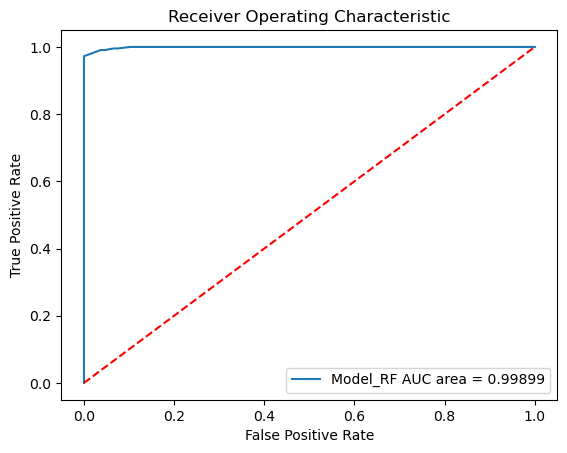

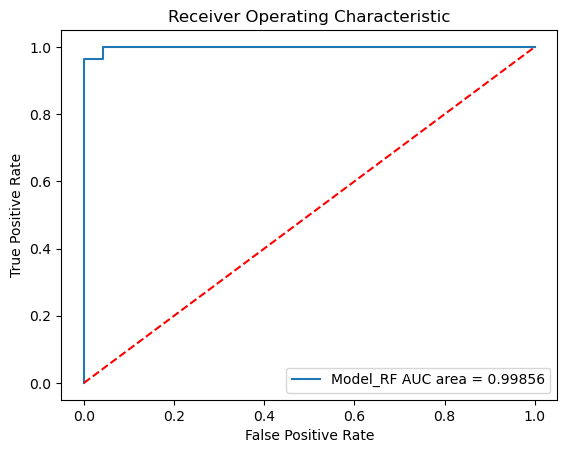

In [19]:
models = [{"label": "Model_RF", "model": model_RF}]

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

SVM

Accuracy: 0.96341
Sensitivity: 0.94828
Specificity: 1.00000
AUC: 0.99353
Confusion Matrix: [[24  0]
 [ 3 55]]


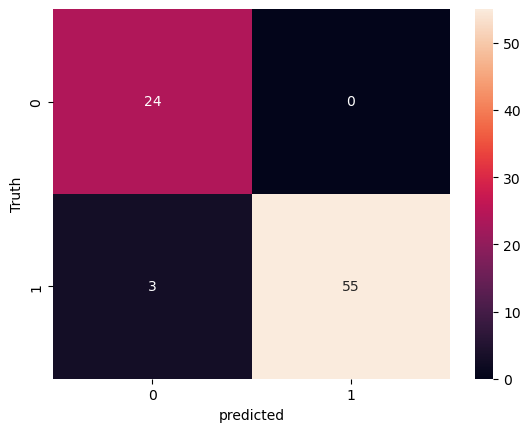

In [20]:
model_SVM = svm.SVC(kernel="linear", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

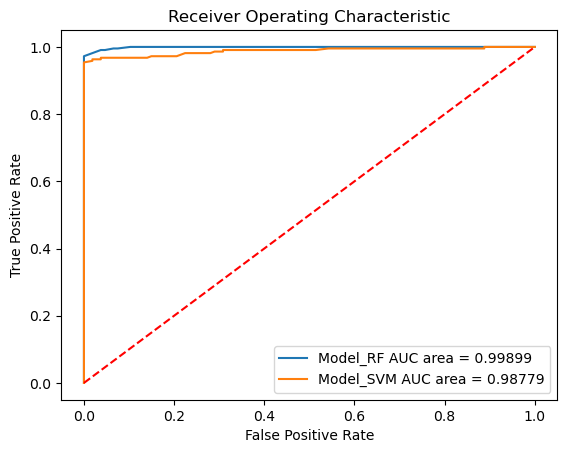

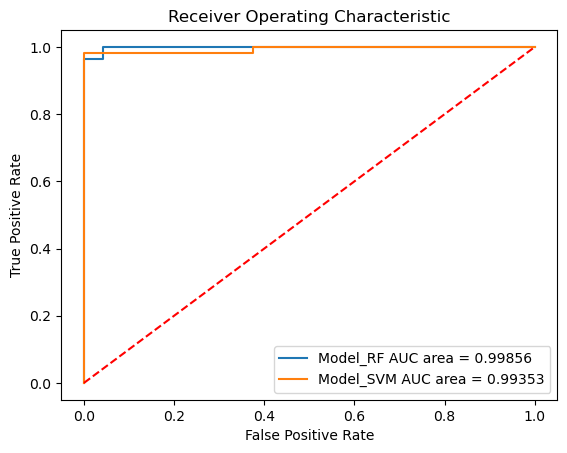

In [21]:
models.append({"label": "Model_SVM", "model": model_SVM})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

Accuracy: 0.95122
Sensitivity: 0.96552
Specificity: 0.91667
AUC: 0.98922
Confusion Matrix: [[22  2]
 [ 2 56]]


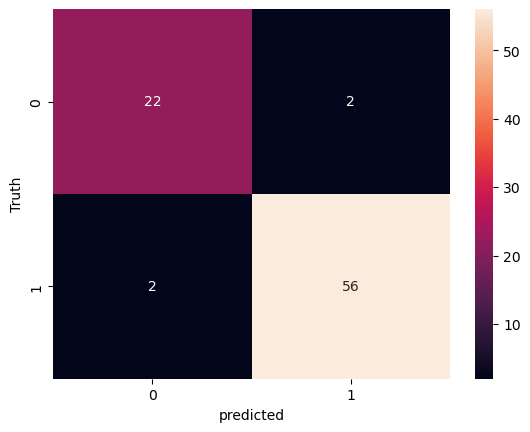

In [23]:
model_GB = GradientBoostingClassifier(n_estimators=40,
                                     learning_rate=0.1,
                                     criterion='friedman_mse',
                                     max_depth=1)

performance_measures = model_training_and_validation(model_GB, "GB", splits)

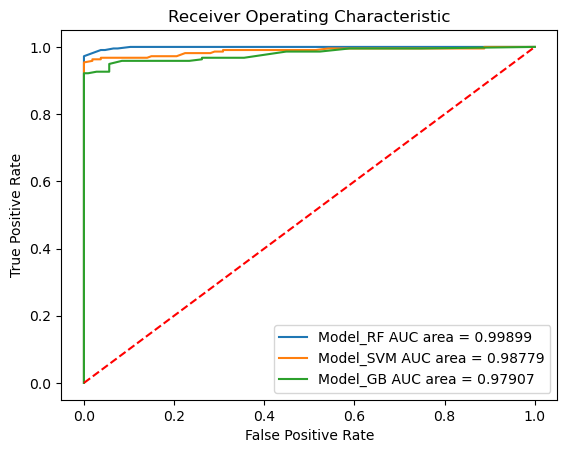

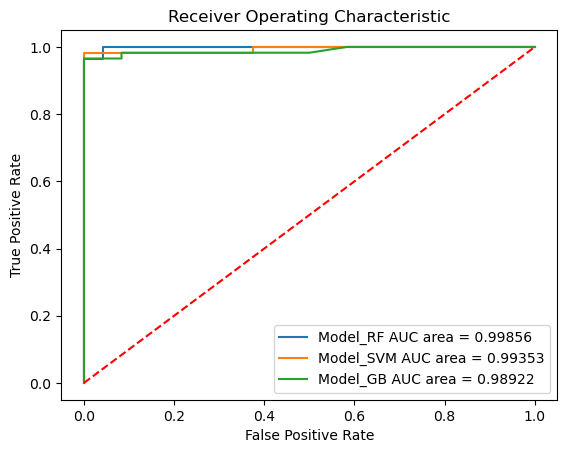

In [24]:
models.append({"label": "Model_GB", "model": model_GB})

plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

ANN

Accuracy: 0.96341
Sensitivity: 0.98276
Specificity: 0.91667
AUC: 0.96911
Confusion Matrix: [[22  2]
 [ 1 57]]


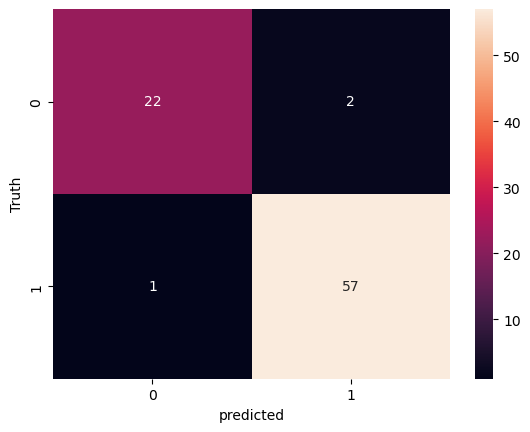

In [25]:
#Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(3, ), activation='identity',
                          solver='lbfgs', alpha=0.0001, max_iter=400)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

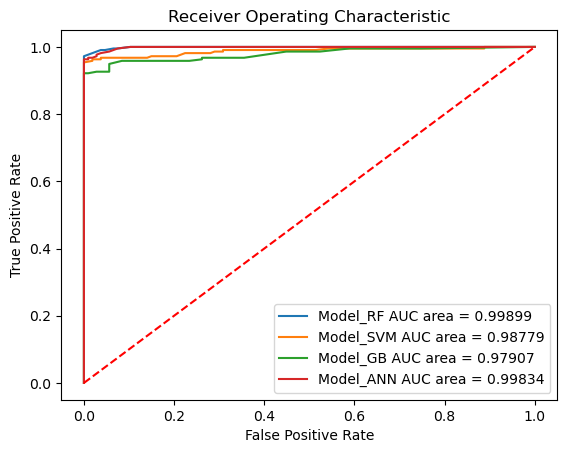

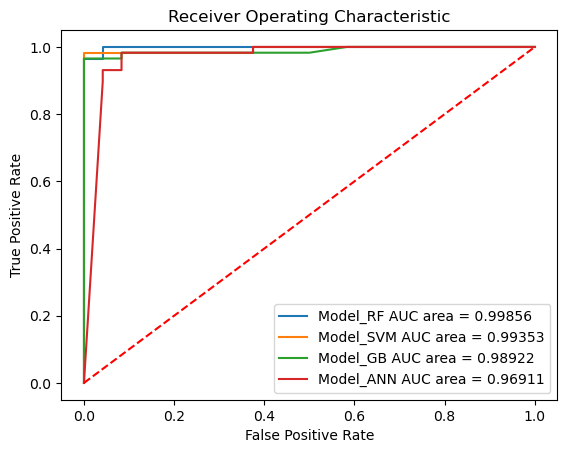

In [26]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})

# Plot roc curve
plot_curve_functions(models, static_train_x, static_train_y)
plot_curve_functions(models, static_test_x, static_test_y)

Classification Using Molecular Features

In [27]:
df2

,cid,smiles,pIC50,activity_label
0,118159240,CC(=O)N1CCc2nc(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)c(...,10.860121,1.0
1,118180377,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=...,10.860121,1.0
2,118180376,CC(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)[C@H](F)C3)...,10.422508,1.0
3,118180374,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(CN...,10.203426,1.0
4,127024467,Cc1nccc2nc(NC3CC3)c(N3CCC(Cc4ccc(F)cc4F)CC3)nc...,8.698970,1.0
...,...,...,...,...
401,118159281,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.468266,0.0
402,118159155,COc1cccc(S(=O)(=O)C2CCN(c3nc4c(nc3NC(C)C)CCN(C...,3.466609,0.0
403,118159118,CC(=O)N1CCc2nc(N3CCN(Cc4ccc(C#N)cc4F)CC3)c(NC(...,3.440213,0.0
404,118159228,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(...,3.407823,0.0


In [28]:
smile = [Chem.MolFromSmiles(i) for i in df2.smiles]
mol = [m for m in smile]
len(mol)

406

In [29]:
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

209
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x000001D58A844790>), ('MaxEStateIndex', <function MaxEStateIndex at 0x000001D58A844670>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x000001D58A844820>), ('MinEStateIndex', <function MinEStateIndex at 0x000001D58A844700>), ('qed', <function qed at 0x000001D58A8475B0>)]


In [30]:
descriptors = [Descriptors.CalcMolDescriptors(i) for i in mol]
rdkit_gpr6 = pd.DataFrame(descriptors)
rdkit_gpr6

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.187820,14.187820,0.034977,-0.532030,0.658737,473.980,444.748,473.199381,176,0,...,0,0,0,0,0,0,0,0,0,0
1,14.018710,14.018710,0.040537,-0.692270,0.679405,488.583,454.311,488.271131,190,0,...,0,0,0,0,0,0,0,0,0,1
2,15.077880,15.077880,0.007235,-1.401722,0.732420,463.504,435.280,463.219510,178,0,...,0,0,0,0,0,0,0,0,0,0
3,14.027118,14.027118,0.103907,-0.662901,0.619150,502.610,466.322,502.286781,196,0,...,0,0,0,0,0,0,0,0,0,0
4,14.030648,14.030648,0.373029,-5.083333,0.440062,523.506,497.298,523.200666,198,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,13.980299,13.980299,0.084153,-0.679987,0.688873,471.552,440.304,471.244582,182,0,...,0,0,0,0,0,0,0,0,0,0
402,13.250627,13.250627,0.029579,-3.463023,0.663173,487.626,454.362,487.225326,184,0,...,0,0,1,0,0,0,0,0,0,0
403,14.306601,14.306601,0.055294,-0.333280,0.747351,451.550,421.310,451.249587,174,0,...,0,0,0,0,0,0,0,0,0,0
404,14.017818,14.017818,0.082053,-0.681796,0.663656,500.594,466.322,500.271131,194,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
rdkit_gpr6.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.0,...,406.000000,406.000000,406.000000,406.0,406.0,406.0,406.0,406.000000,406.000000,406.000000
mean,13.407435,13.407435,0.146775,-2.906237,0.551806,490.560377,465.303273,490.068246,181.921182,0.0,...,0.007389,0.068966,0.019704,0.0,0.0,0.0,0.0,0.022167,0.022167,0.054187
std,1.594267,1.594267,0.162150,2.097198,0.142109,77.633891,74.900296,77.514098,30.455532,0.0,...,0.085748,0.253708,0.139154,0.0,0.0,0.0,0.0,0.147410,0.163303,0.226666
min,4.871601,4.871601,0.000000,-5.083333,0.243006,253.308000,246.252000,252.997968,82.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,13.003812,13.003812,0.040100,-5.083333,0.434120,457.531250,428.293000,457.233928,172.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,13.966414,13.966414,0.082684,-3.226666,0.554611,502.816000,472.048500,502.228169,190.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,14.176661,14.176661,0.202477,-0.682752,0.678792,538.844000,513.289750,538.190170,198.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,15.248740,15.248740,0.786402,0.716349,0.802254,656.641000,629.821000,656.248264,248.000000,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,2.000000,1.000000


Standardization

In [32]:
from sklearn import preprocessing

In [33]:
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(rdkit_gpr6)
x

array([[ 0.49009812,  0.49009812, -0.69032455, ..., -0.15056568,
        -0.13591197, -0.23935678],
       [ 0.38389343,  0.38389343, -0.65599497, ..., -0.15056568,
        -0.13591197,  4.17786374],
       [ 1.04907462,  1.04907462, -0.86162177, ..., -0.15056568,
        -0.13591197, -0.23935678],
       ...,
       [ 0.56469504,  0.56469504, -0.56487122, ..., -0.15056568,
        -0.13591197, -0.23935678],
       [ 0.38333332,  0.38333332, -0.39963949, ..., -0.15056568,
        -0.13591197,  4.17786374],
       [ 0.39827121,  0.39827121, -0.85532486, ..., -0.15056568,
        -0.13591197, -0.23935678]])

In [34]:
rdkit_gpr6_standardized = pd.DataFrame(x, columns=rdkit_gpr6.columns)
rdkit_gpr6_standardized

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.490098,0.490098,-0.690325,1.133482,0.753383,-0.213835,-0.274774,-0.217892,-0.194660,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
1,0.383893,0.383893,-0.655995,1.056981,0.899003,-0.025502,-0.146940,-0.023213,0.265593,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,4.177864
2,1.049075,1.049075,-0.861622,0.718278,1.272524,-0.348942,-0.401338,-0.346800,-0.128910,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
3,0.389174,0.389174,-0.264701,1.071003,0.474473,0.155402,0.013618,0.157824,0.462845,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
4,0.391391,0.391391,1.397058,-1.039379,-0.787299,0.424895,0.427691,0.427965,0.528595,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.359770,0.359770,-0.386677,1.062845,0.965707,-0.245148,-0.334179,-0.243141,0.002591,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
402,-0.098479,-0.098479,-0.723655,-0.265818,0.784637,-0.037844,-0.146258,-0.036721,0.068342,0.0,...,-0.08628,-0.272166,7.053368,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
403,0.564695,0.564695,-0.564871,1.228369,1.377722,-0.503112,-0.588082,-0.501413,-0.260411,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
404,0.383333,0.383333,-0.399639,1.061982,0.788040,0.129402,0.013618,0.131789,0.397094,0.0,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,4.177864


In [35]:
feature_name = np.array(rdkit_gpr6_standardized.columns)
feature_name

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
 

In [36]:
df_desc = df2.copy()
df_rdkit_desc_standard = df_desc[['activity_label']].join(rdkit_gpr6_standardized)
df_rdkit_desc_standard

,activity_label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,0.490098,0.490098,-0.690325,1.133482,0.753383,-0.213835,-0.274774,-0.217892,-0.194660,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
1,1.0,0.383893,0.383893,-0.655995,1.056981,0.899003,-0.025502,-0.146940,-0.023213,0.265593,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,4.177864
2,1.0,1.049075,1.049075,-0.861622,0.718278,1.272524,-0.348942,-0.401338,-0.346800,-0.128910,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
3,1.0,0.389174,0.389174,-0.264701,1.071003,0.474473,0.155402,0.013618,0.157824,0.462845,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
4,1.0,0.391391,0.391391,1.397058,-1.039379,-0.787299,0.424895,0.427691,0.427965,0.528595,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.0,0.359770,0.359770,-0.386677,1.062845,0.965707,-0.245148,-0.334179,-0.243141,0.002591,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
402,0.0,-0.098479,-0.098479,-0.723655,-0.265818,0.784637,-0.037844,-0.146258,-0.036721,0.068342,...,-0.08628,-0.272166,7.053368,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
403,0.0,0.564695,0.564695,-0.564871,1.228369,1.377722,-0.503112,-0.588082,-0.501413,-0.260411,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,-0.239357
404,0.0,0.383333,0.383333,-0.399639,1.061982,0.788040,0.129402,0.013618,0.131789,0.397094,...,-0.08628,-0.272166,-0.141776,0.0,0.0,0.0,0.0,-0.150566,-0.135912,4.177864


UMAP plot (Fingerprint VS Features)

In [37]:
import umap.umap_ as umap
import umap.plot

c:\Users\supak\anaconda3\envs\my-rdkit-env\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\supak\anaconda3\envs\my-rdkit-env\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\supak\anaconda3\envs\my-rdkit-env\lib\site-packages\umap\distances.

In [38]:
rdkit_gpr6_standardized.shape

(406, 209)

In [39]:
umapper = umap.UMAP(n_neighbors=50, 
                    n_components=2,
                    metric='euclidean', 
                    random_state=412
                    )

In [40]:
umap_desc = umapper.fit_transform(rdkit_gpr6_standardized)

In [41]:
umap_desc_x = pd.DataFrame(umap_desc[:, 0], columns = ['x'])
umap_desc_y = pd.DataFrame(umap_desc[:, 1], columns = ['y'])
bioactivity = pd.DataFrame(df["bioactivity"].values, columns = ['bioactivity'])
plot_umap_desc = pd.concat([bioactivity, umap_desc_x, umap_desc_y], axis = 1)
plot_umap_desc

,bioactivity,x,y
0,Active,2.260724,10.456035
1,Active,1.198445,10.869420
2,Active,2.149563,11.671603
3,Active,1.914551,11.015823
4,Active,15.058025,3.398521
...,...,...,...
401,Inactive,2.753379,11.547503
402,Inactive,3.096478,11.901793
403,Inactive,2.891162,10.925720
404,Inactive,1.673467,10.832926


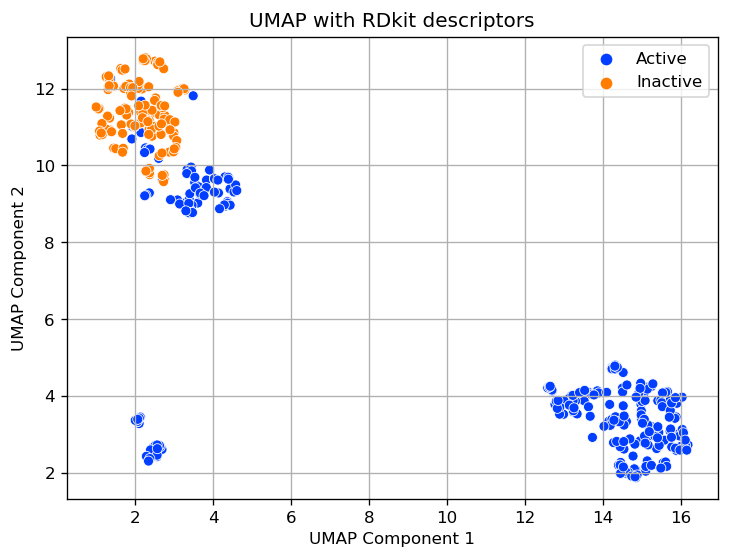

In [42]:
plt.figure(figsize = (7, 5), dpi=120)
sns.scatterplot(x='x', y='y', hue='bioactivity', data=plot_umap_desc, palette='bright')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid()
plt.legend()
plt.title('UMAP with RDkit descriptors', fontsize=12)
plt.show()

ML function for features

In [43]:
def plot_curve_functions_feature(models, test_x, test_y):
    
    fig, ax = plt.subplots()
    
    
    #Loop iterates model list
    for model in models:
        
        #Select model
        ml_model = model["model"]
        
        #Predict test probability
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        
        #Predict class on test set
        test_pred = ml_model.predict(test_x)
        
        #Compute False/True postitive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        
        #Calculate AUC
        auc = roc_auc_score(test_y, test_prob)
        
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.5f}"))
    
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

In [44]:
def model_performance_feature(ml_model, test_x, test_y, verbose=True):
    
    #Predict probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]
    
    #Predict class on test set
    test_pred = ml_model.predict(test_x)
    
    #Performance of test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)#, average='macro') # In case of Multi class, change a binary to micro, macro, weighted or None. pos_label is ignored
    spec = recall_score(test_y, test_pred, pos_label=0)#, average='macro)
    auc = roc_auc_score(test_y, test_prob)#,multi_class='ovr') # in case of Multi class, put function "multi_class = ovr or ovo"
    cm = confusion_matrix(test_y, test_pred)
    
    if verbose:
        print(f"Accuracy: {accuracy:.5f}")
        print(f"Sensitivity: {sens:.5f}")
        print(f"Specificity: {spec:.5f}")
        print(f"AUC: {auc:.5f}")
        print(f"Confusion Matrix: {cm}")

    return accuracy, sens, spec, auc, cm

In [45]:
def model_training_and_validation_feature(ml_model, name, splits, verbose=True):

    train_x, test_x, train_y, test_y = splits

    #Fit model
    ml_model.fit(train_x, train_y)

    #Calculate performance results
    accuracy, sens, spec, auc, cm = model_performance_feature(ml_model, test_x, test_y, verbose)
    
    sns.heatmap(cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('Truth')
    
    return accuracy, sens, spec, auc, cm

Train_test split

In [57]:
(feature_train_x, 
 feature_test_x, 
 feature_train_y,
 feature_test_y) = train_test_split(df_rdkit_desc_standard.drop(['activity_label'], axis=1), df_rdkit_desc_standard['activity_label'], 
                                   test_size=0.2)

splits = [feature_train_x, feature_test_x, feature_train_y, feature_test_y]

print("Training data size:", len(feature_train_x))
print("Test data size:", len(feature_test_x))

Training data size: 324
Test data size: 82


Random Forest (Features) with Boruta Feature Selection

In [58]:
from boruta import BorutaPy

rf = RandomForestClassifier(n_estimators=100, max_depth=5, criterion= "entropy")


feat_selector = BorutaPy(rf, random_state=42, verbose=2, n_estimators='auto', max_iter=50)
feat_selector.fit(feature_train_x.values, feature_train_y.values) #fit to initial train and test set, then apply selected train x, y again into functions

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	209
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	64
Tentative: 	37
Rejected: 	108
Iteration: 	9 / 50
Confirmed: 	64
Tentative: 	37
Rejected: 	108
Iteration: 	10 / 50
Confirmed: 	64
Tentative: 	37
Rejected: 	108
Iteration: 	11 / 50
Confirmed: 	64
Tentative: 	37
Rejected: 	108
Iteration: 	12 / 50
Confirmed: 	64
Tentative: 	29
Rejected: 	116
Iteration: 	13 / 50
Confirmed: 	64
Tentative: 	29
Rejected: 	116
Iteration: 	14 / 50
Confirmed: 	64
Tentative: 	29
Rejected: 	116
Iteration: 	15 / 50
Confirmed: 	64
Tentative: 	29
Rejected: 	116
Iteration: 	16 / 50
Confirmed: 	64
Tentative: 	2

BorutaPy(estimator=RandomForestClassifier(criterion='entropy', max_depth=5,
                                          n_estimators=246,
                                          random_state=RandomState(MT19937) at 0x1D59C6CC940),
         max_iter=50, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1D59C6CC940, verbose=2)

In [59]:
feature_rank = list(zip(feature_name,
                    feat_selector.ranking_,
                    feat_selector.support_
                    ))

In [60]:
for feat in feature_rank:
    print('Feature: {:<30} Rank: {}, Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: MaxAbsEStateIndex              Rank: 1, Keep: True
Feature: MaxEStateIndex                 Rank: 1, Keep: True
Feature: MinAbsEStateIndex              Rank: 1, Keep: True
Feature: MinEStateIndex                 Rank: 1, Keep: True
Feature: qed                            Rank: 1, Keep: True
Feature: MolWt                          Rank: 1, Keep: True
Feature: HeavyAtomMolWt                 Rank: 1, Keep: True
Feature: ExactMolWt                     Rank: 1, Keep: True
Feature: NumValenceElectrons            Rank: 1, Keep: True
Feature: NumRadicalElectrons            Rank: 119, Keep: False
Feature: MaxPartialCharge               Rank: 1, Keep: True
Feature: MinPartialCharge               Rank: 1, Keep: True
Feature: MaxAbsPartialCharge            Rank: 1, Keep: True
Feature: MinAbsPartialCharge            Rank: 1, Keep: True
Feature: FpDensityMorgan1               Rank: 5, Keep: False
Feature: FpDensityMorgan2               Rank: 1, Keep: True
Feature: FpDensityMorgan3           

In [61]:
selected_feature_train_x = feat_selector.transform(feature_train_x.values) #only for x value in train and test, y is still a label
selected_feature_test_x = feat_selector.transform(feature_test_x.values)

In [62]:
splits_boruta = [selected_feature_train_x, selected_feature_test_x, feature_train_y, feature_test_y]

Accuracy: 0.96341
Sensitivity: 0.94828
Specificity: 1.00000
AUC: 0.96624
Confusion Matrix: [[24  0]
 [ 3 55]]


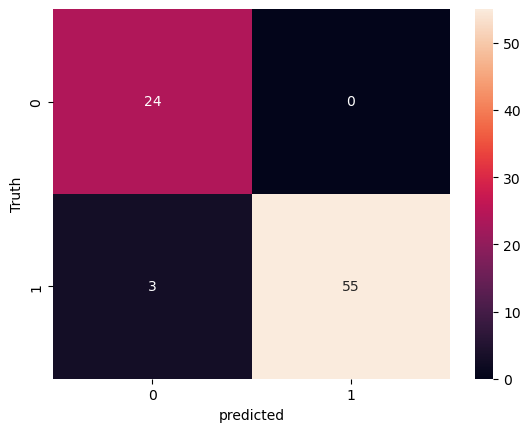

In [63]:
rf_boruta = RandomForestClassifier(n_estimators=100, max_depth=5, criterion= "entropy")


performance_measures = model_training_and_validation_feature(rf_boruta, "RF", splits_boruta)


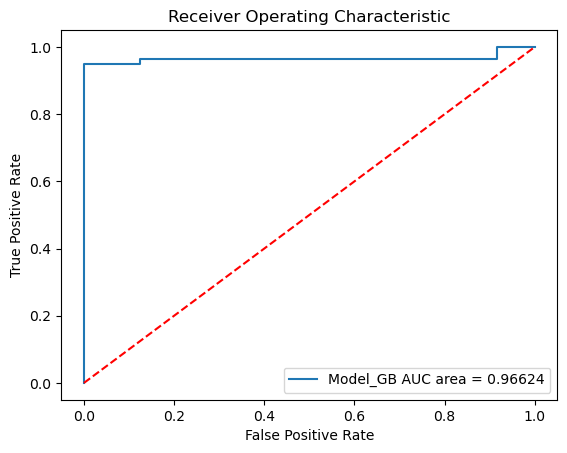

In [64]:
models = [{"label": "Model_GB", "model": rf_boruta}]

# Plot roc curve
plot_curve_functions(models, selected_feature_test_x, feature_test_y)

Gradient Boosting (Features)

In [65]:
param_GB = {
    "n_estimators": 100,
    "criterion": "friedman_mse",
    "learning_rate": 0.1,
    "max_depth": 1,
    "random_state": 42
}
model_GB_feature = GradientBoostingClassifier(**param_GB)

Accuracy: 0.96341
Sensitivity: 0.94828
Specificity: 1.00000
AUC: 0.96049
Confusion Matrix: [[24  0]
 [ 3 55]]


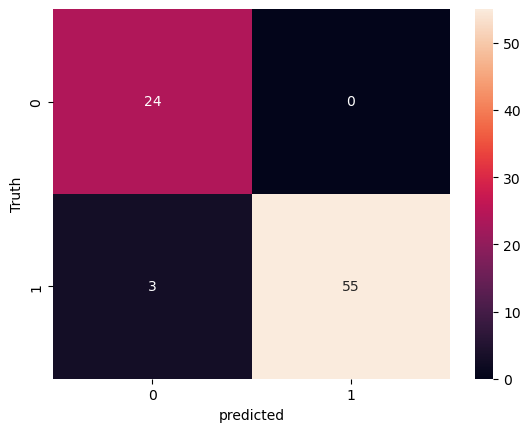

In [66]:
performance_measures = model_training_and_validation(model_GB_feature, "GB", splits)

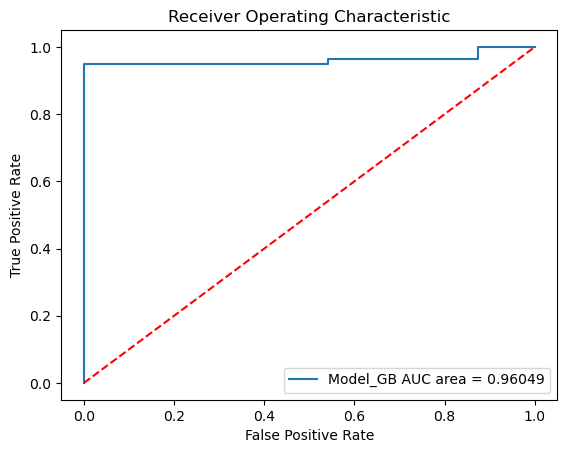

In [67]:
models = [{"label": "Model_GB", "model": model_GB_feature}]

# Plot roc curve
plot_curve_functions(models, feature_test_x, feature_test_y)

In [69]:
feature_importance_GB = pd.Series(model_GB_feature.feature_importances_, index=rdkit_gpr6.columns).sort_values(ascending=False)
feature_importance_GB.head(10)

FractionCSP3      0.860931
SMR_VSA10         0.089065
SlogP_VSA8        0.007860
VSA_EState8       0.006544
SMR_VSA5          0.006406
SlogP_VSA3        0.006244
EState_VSA2       0.005512
BCUT2D_LOGPLOW    0.004359
EState_VSA4       0.003769
SlogP_VSA5        0.001559
dtype: float64

XGBoost

In [70]:
import xgboost as xgb

from scipy.stats import uniform, randint

In [71]:
model_XGB_feature = xgb.XGBClassifier(objective='binary:logistic')

Accuracy: 0.96341
Sensitivity: 0.94828
Specificity: 1.00000
AUC: 0.97198
Confusion Matrix: [[24  0]
 [ 3 55]]


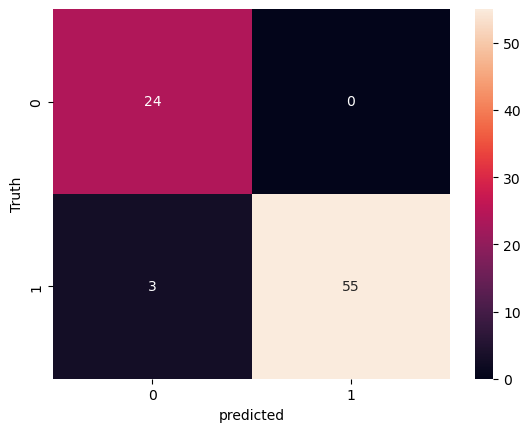

In [72]:
performance_measures = model_training_and_validation_feature(model_XGB_feature, "XGB", splits)

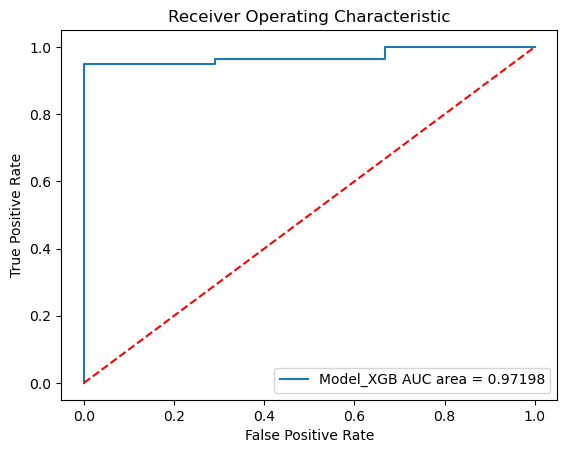

In [73]:
models = [{"label": "Model_XGB", "model": model_XGB_feature}]

# Plot roc curve
plot_curve_functions_feature(models, feature_test_x, feature_test_y)

Hyperparameter Searching

In [74]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [75]:
#model_XGB = xgb.XGBClassifier()
#
#params = {"colsample_bytree": uniform(0.7, 0.3),
#             "gamma": uniform(0, 0.5),
#             "learning_rate": uniform(0.03, 0.3), # default 0.1 
#             "max_depth": randint(2, 6), # default 3
#             "n_estimators": randint(100, 150), # default 100
#             "subsample": uniform(0.6, 0.4)
#}
#
#search = RandomizedSearchCV(model_XGB, param_distributions=params, 
#                            n_iter=100, cv=3, verbose=1, n_jobs=1, return_train_score=True)
#
#search.fit(feature_train_x, feature_train_y)
#
#report_best_scores(search.cv_results_, 3)

In [76]:
param_xgb = {"colsample_bytree": 0.9,
          "gamma": 0.2,
          "learning_rate": 0.2, # default 0.1 
          "max_depth": 3, # default 3
          "n_estimators": 120, # default 100
          "subsample": 0.7,
          "random_state": 42
}

model_XGB = xgb.XGBClassifier(**param_xgb)

Accuracy: 0.96341
Sensitivity: 0.94828
Specificity: 1.00000
AUC: 0.97989
Confusion Matrix: [[24  0]
 [ 3 55]]


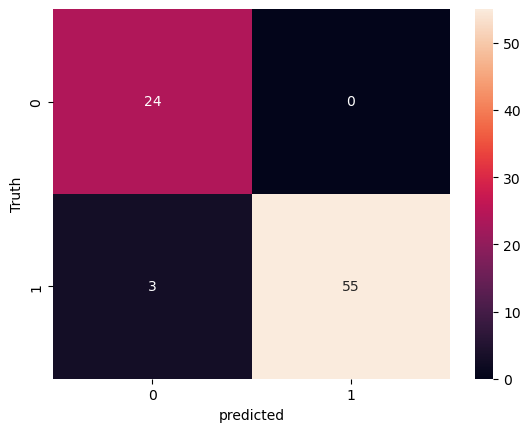

In [77]:
performance_measures = model_training_and_validation_feature(model_XGB, "XGB", splits)

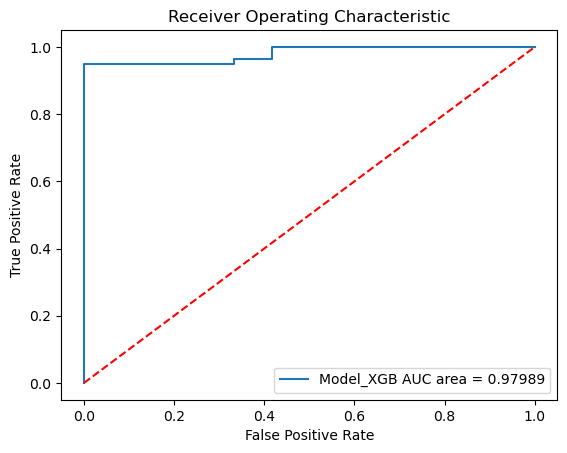

In [78]:
models = [{"label": "Model_XGB", "model": model_XGB}]

# Plot roc curve
plot_curve_functions_feature(models, feature_test_x, feature_test_y)

In [79]:
! pip install graphviz

In [80]:
#import graphviz
#
#xgb.plot_importance(model_XGB)
#
#xgb.to_graphviz(model_XGB, num_trees=model_XGB.best_iteration)